# Task overview

You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

# Data overview

Each sample in the train and test set has the following information:

- The text of a tweet
- A keyword from that tweet (although this may be blank!)
- The location the tweet was sent from (may also be blank)

**Importing libraries**

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="jupyter")
warnings.filterwarnings("ignore", category=DeprecationWarning)

**Loading data**

In [5]:
sns.set_style("whitegrid")

try:
    train_df = pd.read_csv("../data/raw/train.csv")
    test_df = pd.read_csv("../data/raw/test.csv")
    print("Data loaded successfully")
except FileNotFoundError:
    print("File not found. Please check the path.")

Data loaded successfully


In [6]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


**Basic EDA**

In [7]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("\n##################### Types #####################")
    print(dataframe.dtypes)
    print("\n##################### Missing Values #####################")
    print(dataframe.isnull().sum())
    print("\n##################### Duplicates #####################")
    print(dataframe.duplicated().sum())


check_df(train_df)

##################### Shape #####################
(7613, 5)

##################### Types #####################
id          int64
keyword       str
location      str
text          str
target      int64
dtype: object

##################### Missing Values #####################
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

##################### Duplicates #####################
0


C:\Users\37529\AppData\Local\Temp\ipykernel_2020\397467641.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=missing_df, x='pct', y='column', palette='YlOrRd')


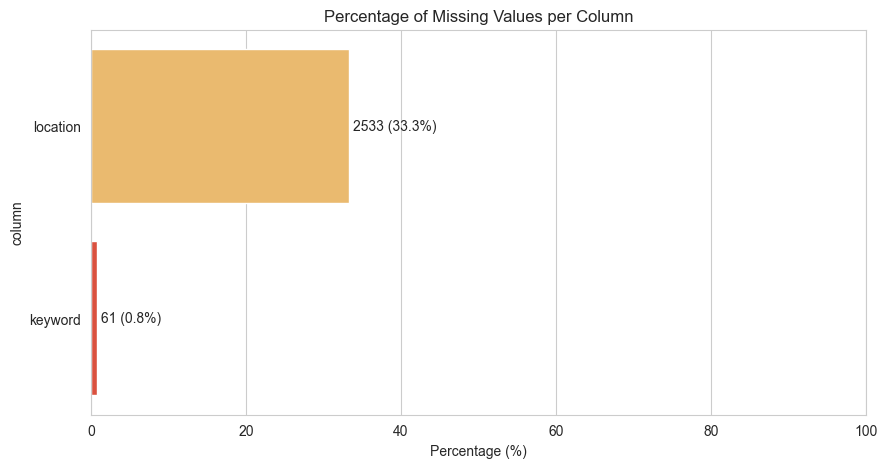

In [8]:
def plot_missing_values(df):
    missing_data = df.isnull().sum()
    missing_pct = (missing_data / len(df)) * 100
    missing_df = pd.DataFrame(
        {"column": missing_data.index, "count": missing_data.values, "pct": missing_pct.values}
    )
    missing_df = missing_df[missing_df["count"] > 0].sort_values("count", ascending=False)

    if missing_df.empty:
        print("No missing values found.")
        return

    plt.figure(figsize=(10, 5))
    sns.barplot(data=missing_df, x="pct", y="column", palette="YlOrRd")
    for i, row in enumerate(missing_df.itertuples()):
        plt.text(row.pct + 0.5, i, f"{row.count} ({row.pct:.1f}%)", va="center")

    plt.title("Percentage of Missing Values per Column")
    plt.xlabel("Percentage (%)")
    plt.xlim(0, 100)
    plt.show()


plot_missing_values(train_df)

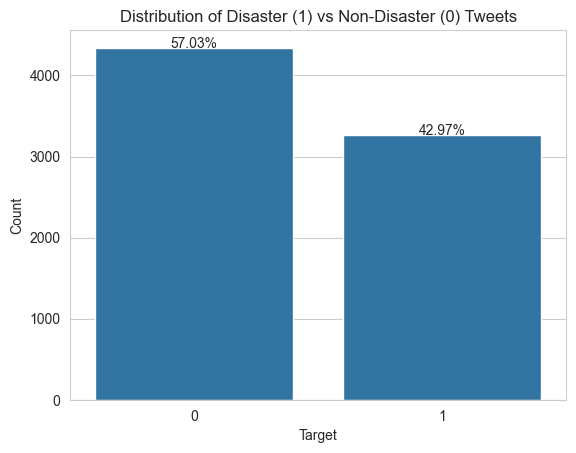

In [9]:
total = len(train_df)
ax = sns.countplot(x="target", data=train_df)

for p in ax.patches:
    height = p.get_height()  # type: ignore
    ax.text(
        p.get_x() + p.get_width() / 2.0,  # type: ignore
        height + 3,
        "{:1.2f}%".format((height / total) * 100),
        ha="center",
    )

plt.title("Distribution of Disaster (1) vs Non-Disaster (0) Tweets")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()

In [10]:
duplicate_texts = train_df[train_df.duplicated(subset=["text"], keep=False)]
print(f"Количество дубликатов по тексту: {duplicate_texts.shape[0]}")

Количество дубликатов по тексту: 179


In [11]:
duplicate_texts = train_df[train_df.duplicated(subset=["text"], keep=False)]

inconsistent = duplicate_texts.groupby("text")["target"].nunique()

inconsistent_texts = inconsistent[inconsistent > 1].index

print(f"Removing {len(inconsistent_texts)} inconsistent texts")

# check if it creates a copy
train_df_clean = train_df[~train_df["text"].isin(inconsistent_texts)].copy()

print("New shape:", train_df_clean.shape)

Removing 18 inconsistent texts
New shape: (7558, 5)


In [12]:
from disaster_tweets.preprocessing import extract_features

test_df = pd.DataFrame(
    {
        "text": [
            "Fire in California!!! Visit https://cnn.com now!!! #disaster",
            "Huge floood in USA omg sooo scaryyyy 😭😭",
            "Explosion reported in U.S. at 304 area",
            "Earthquake in united states... stay safe!!!",
            "@john check this out www.bbc.com/news",
            "Flood in Londoon &amp; heavy rain %20 everywhere",
            "No disaster here just sunny day ☀️",
            None,
            "WTF is happening in Californiiaaaa??? #panic #USA",
            "<b>Storm alert</b> in New York!!! Visit http://weather.com",
        ],
        "location": [
            "US",
            "usa",
            "United States",
            "u.s.",
            "California",
            "Londoon",
            "",
            None,
            "Californiia",
            "New York",
        ],
    }
)
result = extract_features(test_df)
print(
    result[
        [
            "text",
            "clean_text",
            "url_count",
            "top_domain",
            "has_url",
            "hashtag_count",
            "typo_count",
            "location",
            "location_normalized",
        ]
    ]
)

                                                text  \
0  Fire in California!!! Visit https://cnn.com no...   
1            Huge floood in USA omg sooo scaryyyy 😭😭   
2             Explosion reported in U.S. at 304 area   
3        Earthquake in united states... stay safe!!!   
4              @john check this out www.bbc.com/news   
5   Flood in Londoon &amp; heavy rain %20 everywhere   
6                 No disaster here just sunny day ☀️   
7                                                NaN   
8  WTF is happening in Californiiaaaa??? #panic #USA   
9  <b>Storm alert</b> in New York!!! Visit http:/...   

                           clean_text  url_count   top_domain  has_url  \
0      fire california visit disaster          1      cnn.com     True   
1      huge flood us om soon scaryyyy          0          NaN    False   
2               explosion report area          0          NaN    False   
3  earthquake united states stay safe          0          NaN    False   
4            

**Tweet analysis**

*Normalization and cleaning before analysis*

In [ ]:
from disaster_tweets.preprocessing import extract_features

df_eda = extract_features(train_df_clean)

print(df_eda[["text", "clean_text", "url_count", "top_domain", "typo_count", "has_typos"]].head(10))

df_eda.groupby("target")[["url_count", "typo_count"]].mean()

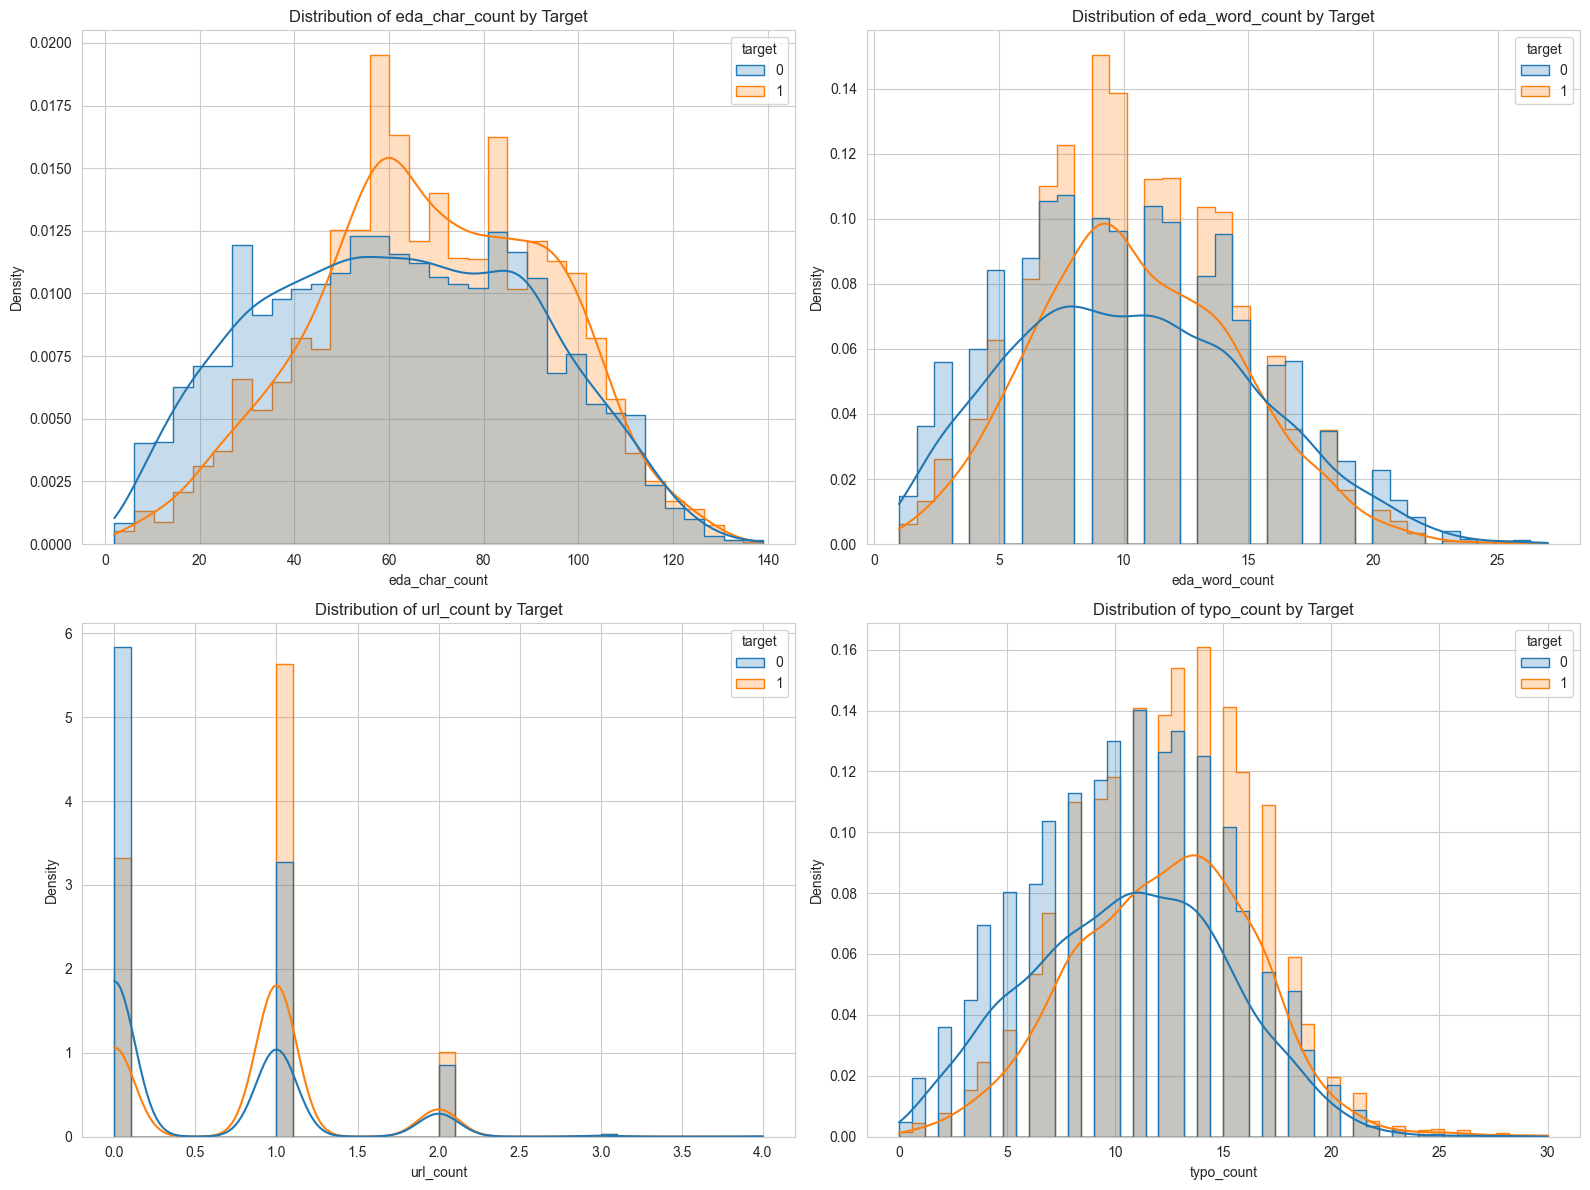

In [ ]:
df_eda["eda_char_count"] = df_eda["clean_text"].str.len()
df_eda["eda_word_count"] = df_eda["clean_text"].str.split().apply(len)

meta_features = ["eda_char_count", "eda_word_count", "url_count", "typo_count"]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, feature in enumerate(meta_features):
    sns.histplot(
        data=df_eda,
        x=feature,
        hue="target",
        kde=True,
        element="step",
        stat="density",
        common_norm=False,
        ax=axes[i],
    )
    axes[i].set_title(f"Distribution of {feature} by Target")

plt.tight_layout()
plt.show()

**N-gram analysis**

In [ ]:
def plot_top_ngrams(corpus, title, n_gram=1, top_k=20):
    vec = CountVectorizer(stop_words="english", ngram_range=(n_gram, n_gram), min_df=5).fit(corpus)

    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)  # type: ignore
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_k]
    df_plot = pd.DataFrame(words_freq, columns=["Word", "Count"])
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_plot, x="Count", y="Word")
    plt.title(title)
    plt.show()

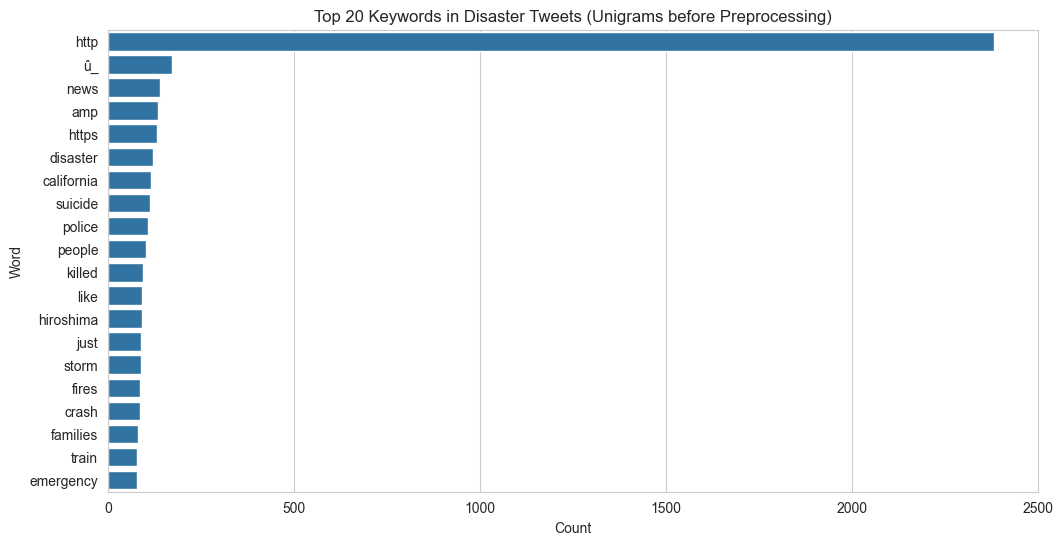

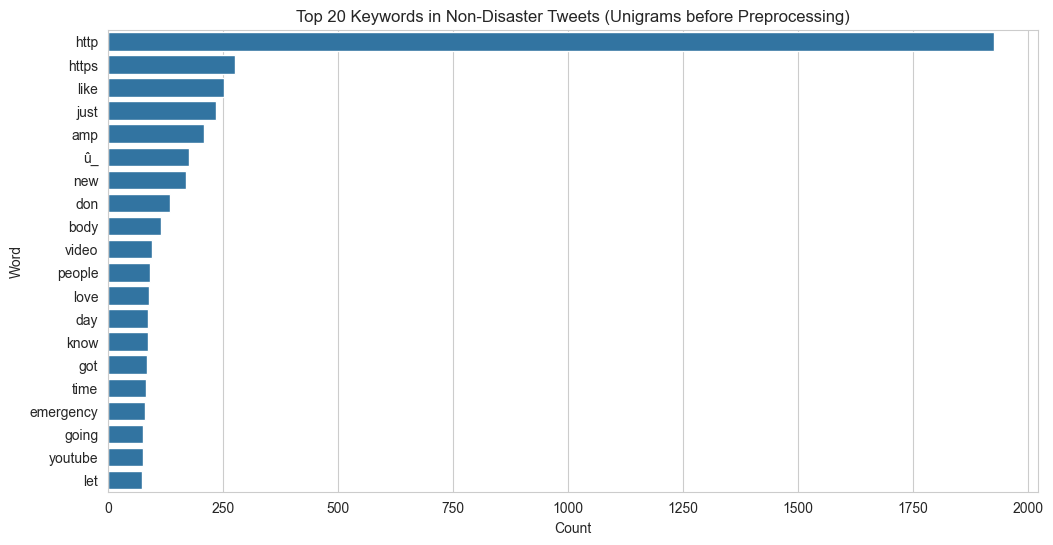

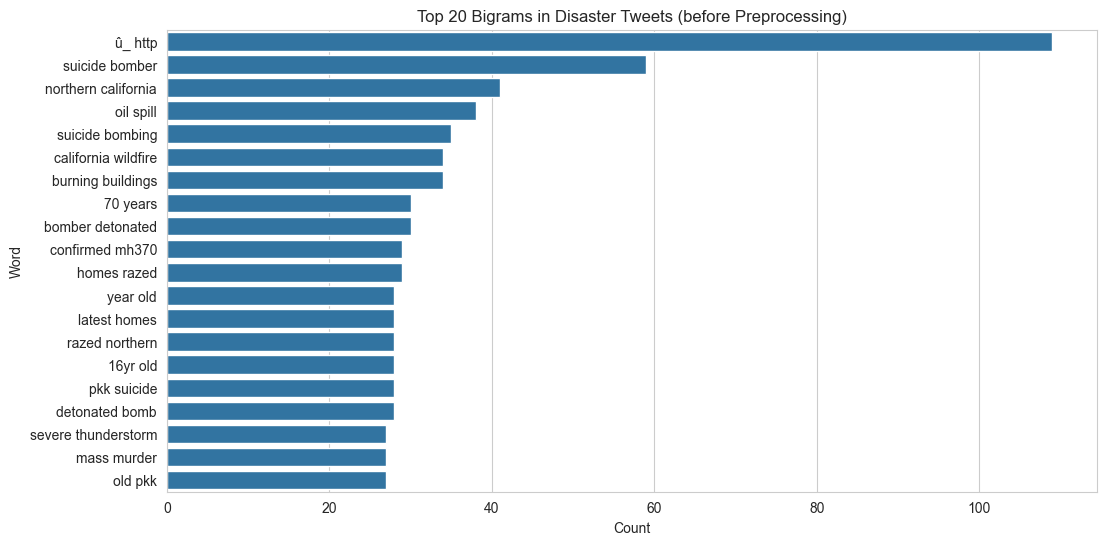

In [ ]:
disaster_text = df_eda[df_eda["target"] == 1]["text"]
non_disaster_text = df_eda[df_eda["target"] == 0]["text"]

plot_top_ngrams(
    disaster_text, "Top 20 Keywords in Disaster Tweets (Unigrams before Preprocessing)", n_gram=1
)
plot_top_ngrams(
    non_disaster_text,
    "Top 20 Keywords in Non-Disaster Tweets (Unigrams before Preprocessing)",
    n_gram=1,
)
plot_top_ngrams(disaster_text, "Top 20 Bigrams in Disaster Tweets (before Preprocessing)", n_gram=2)

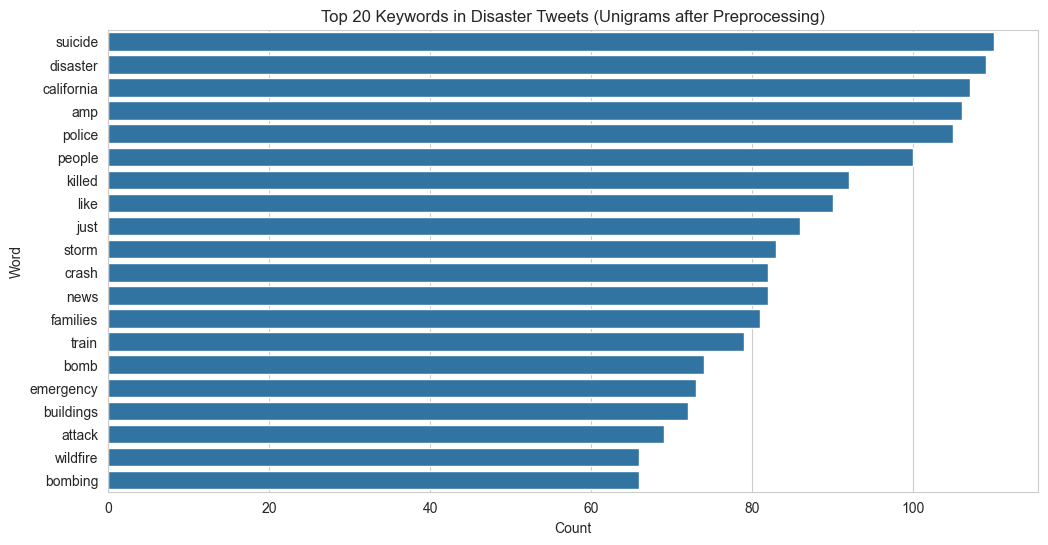

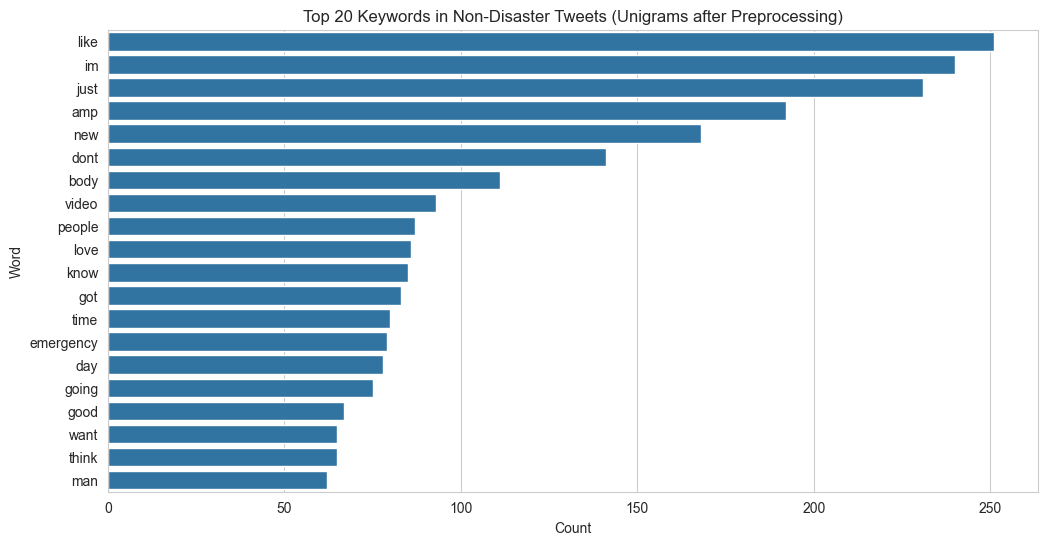

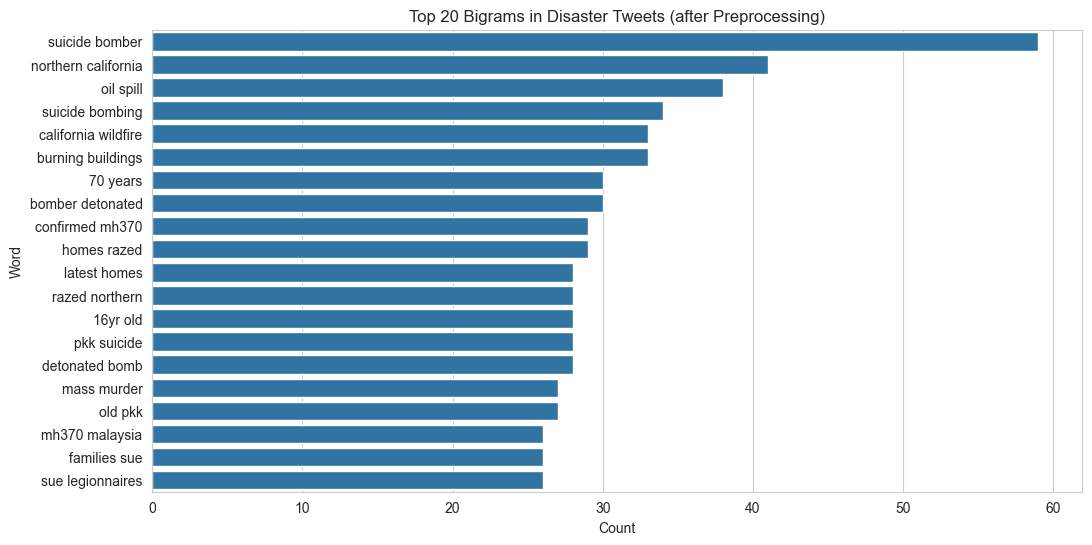

In [ ]:
disaster_text = df_eda[df_eda["target"] == 1]["clean_text"]
non_disaster_text = df_eda[df_eda["target"] == 0]["clean_text"]

plot_top_ngrams(
    disaster_text, "Top 20 Keywords in Disaster Tweets (Unigrams after Preprocessing)", n_gram=1
)
plot_top_ngrams(
    non_disaster_text,
    "Top 20 Keywords in Non-Disaster Tweets (Unigrams after Preprocessing)",
    n_gram=1,
)
plot_top_ngrams(disaster_text, "Top 20 Bigrams in Disaster Tweets (after Preprocessing)", n_gram=2)

**Location and keyword analysis**

In [ ]:
top_keywords = df_eda["keyword"].value_counts().head(20)
print("Top 20 keywords overall:\n", top_keywords)

top_keywords_disaster = df_eda[df_eda["target"] == 1]["keyword"].value_counts().head(20)
print("\nTop 20 keywords in disaster tweets:\n", top_keywords_disaster)

top_keywords_non_disaster = df_eda[df_eda["target"] == 0]["keyword"].value_counts().head(20)
print("\nTop 20 keywords in non-disaster tweets:\n", top_keywords_non_disaster)

Top 20 keywords overall:
 keyword
fatalities     45
armageddon     42
deluge         42
body%20bags    41
damage         41
harm           41
collided       40
evacuate       40
fear           40
outbreak       40
siren          40
twister        40
windstorm      40
collision      39
derailment     39
earthquake     39
explosion      39
famine         39
flames         39
sinkhole       39
Name: count, dtype: int64

Top 20 keywords in disaster tweets:
 keyword
derailment               39
outbreak                 39
wreckage                 39
debris                   37
oil%20spill              37
typhoon                  37
evacuated                32
rescuers                 32
suicide%20bomb           32
suicide%20bombing        32
nuclear%20disaster       31
razed                    31
airplane%20accident      30
earthquake               30
suicide%20bomber         30
bridge%20collapse        29
collision                29
wildfire                 29
buildings%20on%20fire    28
ca

C:\Users\37529\AppData\Local\Temp\ipykernel_21156\3564845033.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_keywords_disaster.values, y=top_keywords_disaster.index, palette="viridis")


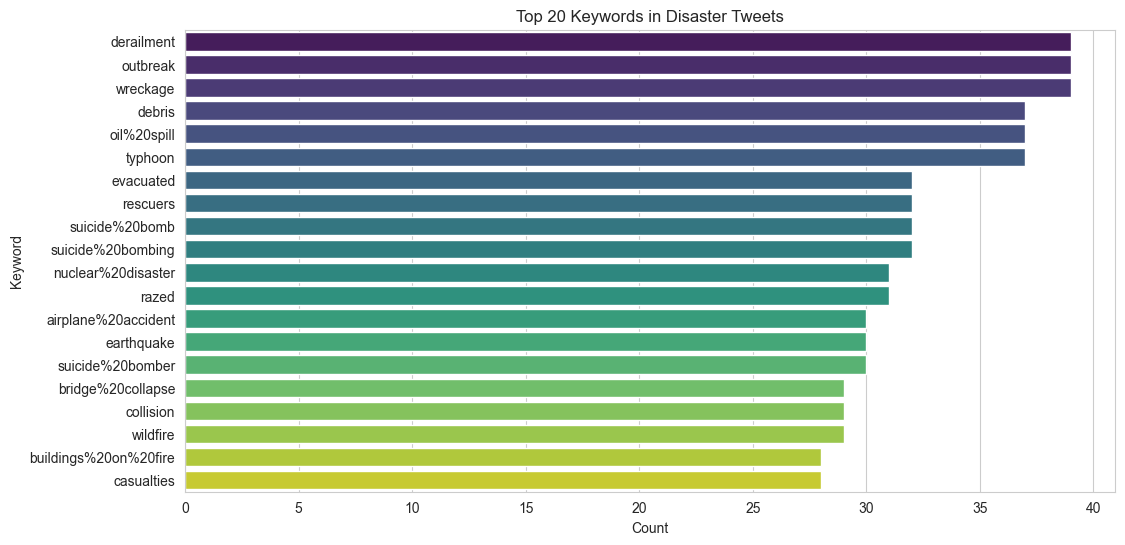

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=top_keywords_disaster.values, y=top_keywords_disaster.index, palette="viridis")
plt.title("Top 20 Keywords in Disaster Tweets")
plt.xlabel("Count")
plt.ylabel("Keyword")
plt.show()

C:\Users\37529\AppData\Local\Temp\ipykernel_21156\2146508980.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


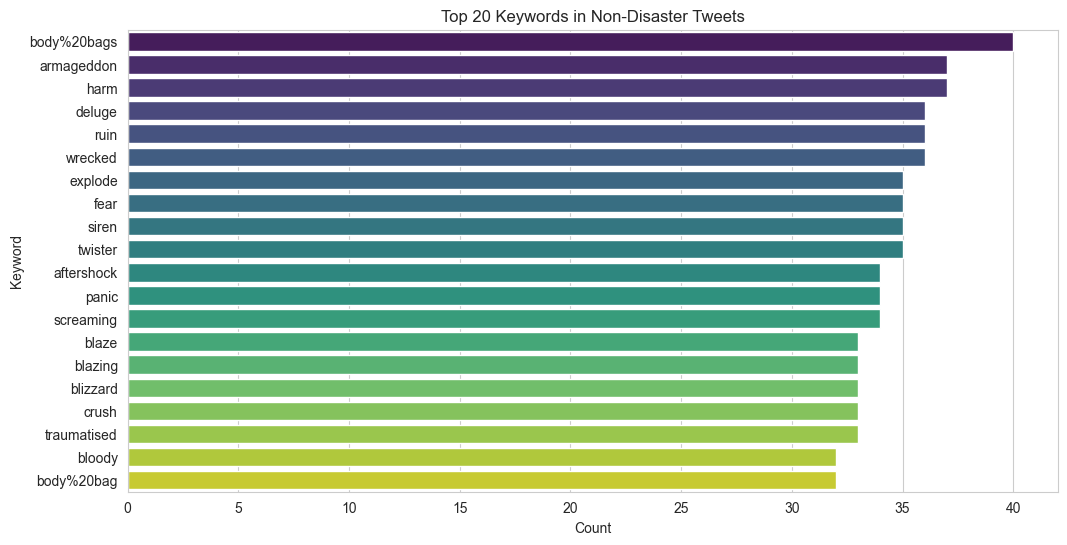

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_keywords_non_disaster.values, y=top_keywords_non_disaster.index, palette="viridis"
)
plt.title("Top 20 Keywords in Non-Disaster Tweets")
plt.xlabel("Count")
plt.ylabel("Keyword")
plt.show()

In [ ]:
top_locations = df_eda["location"].value_counts().head(20)
print("\nTop 20 locations overall:\n", top_locations)

top_locations_disaster = df_eda[df_eda["target"] == 1]["location"].value_counts().head(20)
print("\nTop 20 locations in disaster tweets:\n", top_locations_disaster)

top_locations_non_disaster = df_eda[df_eda["target"] == 0]["location"].value_counts().head(20)
print("\nTop 20 locations in non-disaster tweets:\n", top_locations_non_disaster)


Top 20 locations overall:
 location
USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Washington, DC      21
Kenya               20
Worldwide           19
Australia           18
Chicago, IL         18
California          17
New York, NY        15
California, USA     15
Everywhere          15
San Francisco       14
Name: count, dtype: int64

Top 20 locations in disaster tweets:
 location
USA                 67
United States       27
Nigeria             22
India               20
Mumbai              19
UK                  16
London              16
New York            16
Washington, DC      15
Canada              13
Worldwide           12
Australia            9
Washington, D.C.     9
Chicago, IL          9
Indonesia            8
California, USA      8
Earth                8
Los Angeles, CA      8
Nashville, TN  

C:\Users\37529\AppData\Local\Temp\ipykernel_21156\3986294582.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_locations_disaster.values, y=top_locations_disaster.index, palette="viridis")


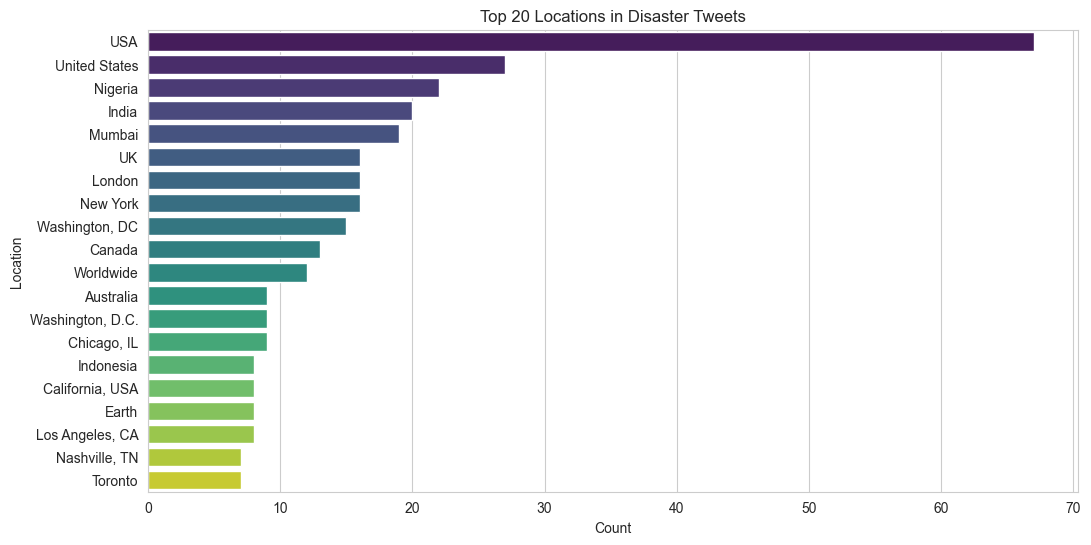

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=top_locations_disaster.values, y=top_locations_disaster.index, palette="viridis")
plt.title("Top 20 Locations in Disaster Tweets")
plt.xlabel("Count")
plt.ylabel("Location")
plt.show()

C:\Users\37529\AppData\Local\Temp\ipykernel_21156\2781602417.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


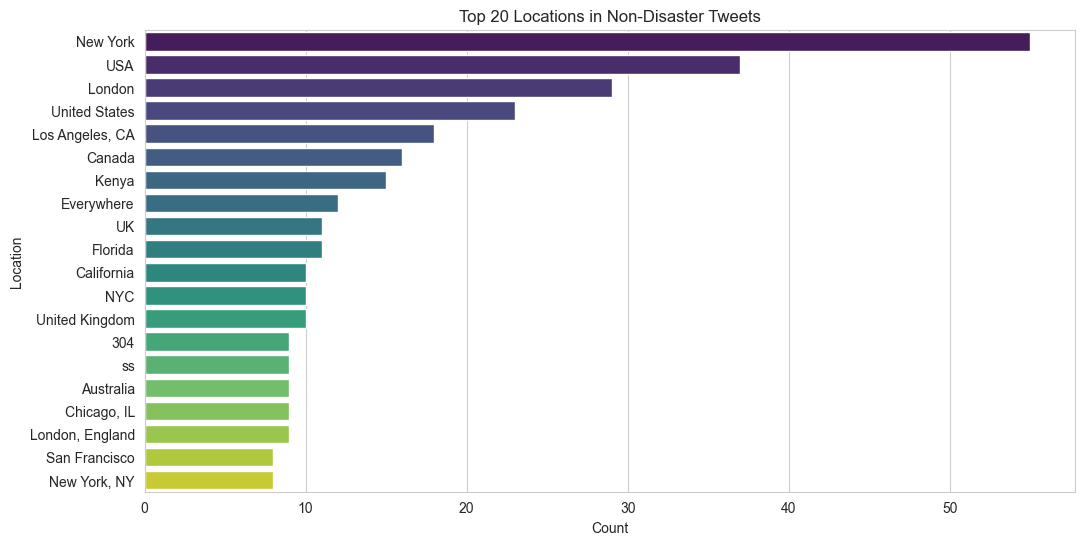

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_locations_non_disaster.values, y=top_locations_non_disaster.index, palette="viridis"
)
plt.title("Top 20 Locations in Non-Disaster Tweets")
plt.xlabel("Count")
plt.ylabel("Location")
plt.show()

In [ ]:
# =============================================================================
# Missing values analysis in keyword and location
# =============================================================================

print("\n" + "=" * 70)
print("MISSING VALUES ANALYSIS IN KEYWORD AND LOCATION")
print("=" * 70)

df_eda["keyword_na"] = df_eda["keyword"].isna()
df_eda["location_na"] = df_eda["location"].isna()
df_eda["both_na"] = df_eda["keyword_na"] & df_eda["location_na"]

df_eda["text_len"] = df_eda["text"].str.len()
df_eda["word_count"] = df_eda["text"].str.split().str.len()
df_eda["has_url"] = df_eda["text"].str.contains(r"http|www\.|https", regex=True, na=False)
df_eda["has_mention"] = df_eda["text"].str.contains(r"@\w+", regex=True, na=False)
df_eda["has_hashtag"] = df_eda["text"].str.contains(r"#\w+", regex=True, na=False)

# 1. Count and percentage of missing values
print("\nCount and percentage of missing values:")
miss_summary = pd.DataFrame(
    {
        "count": [df_eda["keyword_na"].sum(), df_eda["location_na"].sum(), df_eda["both_na"].sum()],
        "percent": [
            df_eda["keyword_na"].mean() * 100,
            df_eda["location_na"].mean() * 100,
            df_eda["both_na"].mean() * 100,
        ],
    },
    index=["keyword missing", "location missing", "both missing"],
)
print(miss_summary.round(2))

# 2. Missing rate by target
print("\nMissing rate by target (0 = non-disaster, 1 = disaster):")
miss_by_target = df_eda.groupby("target")[["keyword_na", "location_na", "both_na"]].mean() * 100
print(miss_by_target.round(2))

# 3. Average text length and word count by missing combinations
print("\nAverage text length and word count by missing combinations:")
len_by_miss = (
    df_eda.groupby(["keyword_na", "location_na"], observed=True)[["text_len", "word_count"]]
    .mean()
    .round(1)
)
len_by_miss.columns = ["avg char length", "avg word count"]
print(len_by_miss)

# 4. Percentage of tweets with URL / mention / hashtag by missing combinations
print("\nPercentage of tweets with URL / @ / # by missing combinations:")
media_by_miss = (
    df_eda.groupby(["keyword_na", "location_na"], observed=True)[
        ["has_url", "has_mention", "has_hashtag"]
    ].mean()
    * 100
)
print(media_by_miss.round(1))

# 5. Most frequent keywords when location is missing
print("\nTop 12 keywords when location is missing (including NaN):")
print(df_eda[df_eda["location_na"]]["keyword"].value_counts(dropna=False).head(12))

# 6. Most frequent locations when keyword is missing
print("\nTop 12 locations when keyword is missing (including NaN):")
print(df_eda[df_eda["keyword_na"]]["location"].value_counts(dropna=False).head(12))

# 7. Tweets where both keyword and location are missing
both_na_texts = df_eda[df_eda["both_na"]]["text"]
print(f"\nNumber of tweets where both fields are missing: {len(both_na_texts)}")
if len(both_na_texts) > 0:
    print("\nRandom sample of texts where both keyword and location are missing:")
    print(both_na_texts.sample(min(10, len(both_na_texts))).tolist())

# 8. Visualization - missing rate by target
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
sns.barplot(x=miss_by_target.index, y=miss_by_target["keyword_na"], ax=ax[0], palette="viridis")
ax[0].set_title("Keyword missing rate by target (%)")
ax[0].set_xlabel("Target")
ax[0].set_ylabel("Missing %")

sns.barplot(x=miss_by_target.index, y=miss_by_target["location_na"], ax=ax[1], palette="viridis")
ax[1].set_title("Location missing rate by target (%)")
ax[1].set_xlabel("Target")
ax[1].set_ylabel("Missing %")

sns.barplot(x=miss_by_target.index, y=miss_by_target["both_na"], ax=ax[2], palette="viridis")
ax[2].set_title("Both missing rate by target (%)")
ax[2].set_xlabel("Target")
ax[2].set_ylabel("Missing %")

plt.tight_layout()
plt.show()

**Typo analysis**

In [ ]:
print("=== Typos Analysis ===")
print("Avg typo_count overall:", df_eda["typo_count"].mean().round(2))
print("Avg typo_count in disaster:", df_eda[df_eda["target"] == 1]["typo_count"].mean().round(2))
print(
    "Avg typo_count in non-disaster:", df_eda[df_eda["target"] == 0]["typo_count"].mean().round(2)
)
print("\nHas typos distribution:\n", df_eda["has_typos"].value_counts(normalize=True))

=== Typos Analysis ===
Avg typo_count overall: 11.33
Avg typo_count in disaster: 12.29
Avg typo_count in non-disaster: 10.61

Has typos distribution:
 has_typos
1    0.97592
0    0.02408
Name: proportion, dtype: float64


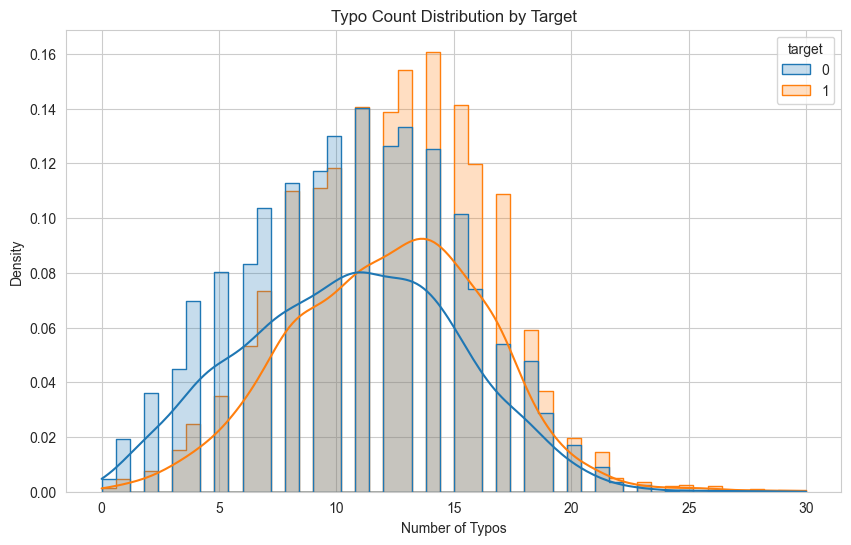

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_eda,
    x="typo_count",
    hue="target",
    kde=True,
    element="step",
    stat="density",
    common_norm=False,
)
plt.title("Typo Count Distribution by Target")
plt.xlabel("Number of Typos")
plt.ylabel("Density")
plt.show()

C:\Users\37529\AppData\Local\Temp\ipykernel_21156\2130446169.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_typos.index, y=mean_typos.values, palette="viridis")


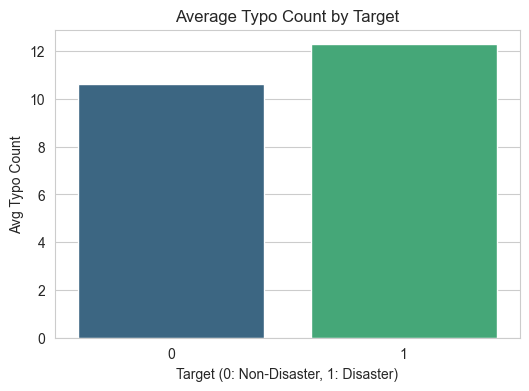

In [ ]:
mean_typos = df_eda.groupby("target")["typo_count"].mean()
plt.figure(figsize=(6, 4))
sns.barplot(x=mean_typos.index, y=mean_typos.values, palette="viridis")
plt.title("Average Typo Count by Target")
plt.xlabel("Target (0: Non-Disaster, 1: Disaster)")
plt.ylabel("Avg Typo Count")
plt.show()

In [ ]:
print(
    "\nTypo count correlation with meta features:\n",
    df_eda[["typo_count", "url_count"]].corr()["typo_count"],
)


Typo count correlation with meta features:
 typo_count    1.000000
url_count     0.363248
Name: typo_count, dtype: float64
